In [1]:
import h5py
import pandas as pd
import json
import numpy as np
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as ssp
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
import pickle
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import itertools
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import coo_matrix, csr_matrix
from collections import Counter
import pickle
from sklearn.utils import shuffle
from os.path import join as pjoin
from tqdm import tqdm
import os
import joblib
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import importlib 
from sklearn.preprocessing import normalize as sk_normalize
import pytorch_lightning as pl
from os.path import join as pjoin
from scipy import sparse

In [2]:
import time
int(time.time())

1657081930

In [3]:
torch.cuda.set_device(1)

In [4]:
fname = "procseed_data_with_aug"

In [5]:
n_models = 3 

In [6]:
lm_feats = joblib.load('%s/lm_feats' % fname)

In [7]:
tr_ds = joblib.load('%s/tr_ds' % fname)
val_ds = joblib.load("%s/val_ds" % fname) 
id2idx = joblib.load('%s/id2idx' % fname)
idx2id = {y:x for (x,y) in id2idx.items()}
n_items = len(id2idx)

In [8]:
val_csv = joblib.load("%s/val_csv" % fname)
tr_csv = joblib.load('%s/tr_csv' % fname)

In [9]:
lr = 1.5 * 1e-4
import mlps
importlib.reload(mlps)

def get_model(dim=256):
    return mlps.MLP2(lm_feats.toarray(), tr_ds.matrices, 
                    tr_ds.categoricals,  
                    tr_ds.tr_scalar,
                    n_items=n_items, 
                    dim=np.random.choice([256]), 
                    layer_dim=np.random.choice([3000]),
                    dropout=np.random.choice([0.3, 0.35]),
                    use_cat=False)

mlp_models = [get_model() for x in range(n_models)]

def get_opts(model):
    wd = np.random.choice([1e-3])
    return torch.optim.Adam(model.parameters(),  lr=lr, weight_decay=wd)
    
opts = [get_opts(model) for model in mlp_models]

for m in mlp_models:
    m.cuda()
    m.train()

lf = torch.nn.CrossEntropyLoss()


item_last_20
item_last_5
item_last_2
item_last_1
item_last_5_feats
item_last_3_feats
item_last_1_feats
item_last_20
item_last_5
item_last_2
item_last_1
item_last_5_feats
item_last_3_feats
item_last_1_feats
item_last_20
item_last_5
item_last_2
item_last_1
item_last_5_feats
item_last_3_feats
item_last_1_feats


이렇게 3개고 last view만 aug해줬을 때 성능이 0.1928이 나옴?
0.3, 0.35, 0.3 
5e-3, 5e-3 3e-3

In [10]:
tr_dls = [DataLoader(tr_ds,
                   batch_size=256, shuffle=True,
                   num_workers=2, prefetch_factor=2,
#                    persistent_workers=True,
                   pin_memory=True) for _ in range(n_models)]

In [11]:
def validate(model, val_ds, use_filter=True, skip_val_only=False):
    hr = []
    model = model.eval()
    s = 0
    tot_mrr = []
    ii = 0
    for input in DataLoader(val_ds, batch_size=250, shuffle=False):
        (target_idx, _), (ret_mat, ret_cat, ret_scalar) = input
        for k in ret_mat:
            ret_mat[k] = ret_mat[k].cuda()
        for k in ret_cat:
            ret_cat[k] = ret_cat[k].cuda()
#         ret_cat = {}
        ret_scalar = ret_scalar.cuda()
        ret = model.forward(ret_mat, ret_cat, ret_scalar,)
        ret[ret_mat['item_bow'].bool()] = -1000000.0
#         ret[:, ~z] = -10000000.0
        top_rec = (-ret).argsort(-1)[:, :100].cpu()

        
        if skip_val_only:
            top_rec = top_rec[target_idx != 29999]
            target_idx = target_idx[target_idx != 29999]
            
        mrr = (top_rec == target_idx.unsqueeze(1)).float().numpy() 
        mrr = (mrr / np.expand_dims(np.arange(1, 1 + 100), 0))
        mrr = mrr.sum(-1)
        tot_mrr.extend(mrr.tolist())
#         break
    model = model.train()
    return np.mean(tot_mrr)

In [12]:
def flatten(x):
    ret = []
    for k in x:
        ret.extend(k)
    return ret

In [13]:
def validate_models(models, val_ds, use_filter=True, skip_val_only=False, r=None):
    hr = []
    for model in models:
        model = model.eval()
    s = 0
    tot_mrr = []
    ii = 0
    for input in DataLoader(val_ds, batch_size=250, shuffle=False):
        (target_idx, _), (ret_mat, ret_cat, ret_scalar) = input
        for k in ret_mat:
            ret_mat[k] = ret_mat[k].cuda()
        for k in ret_cat:
            ret_cat[k] = ret_cat[k].cuda()
        ret_scalar = ret_scalar.cuda()
        rret = []
        for model in models:
            ret = model.forward(ret_mat, ret_cat, ret_scalar,)
            rret.append(ret)
        ret = torch.stack(rret)
        ret = torch.mean(ret, 0)
        ret[ret_mat['item_bow'].bool()] = -10000.0
        if r is not None:
            print(r.shape)
            ret[:, ~r] = -100000.0
        top_rec = (-ret).argsort(-1)[:, :100].detach().cpu()

#         if skip_val_only:
#         top_rec = top_rec[target_idx != 29999]
#         target_idx = target_idx[target_idx != 29999]

        mrr = (top_rec == target_idx.unsqueeze(1)).float().numpy()
        hitst = mrr[:, :5].sum(-1)
        mrr = (mrr / np.expand_dims(np.arange(1, 1 + 100), 0)).sum(-1)
        tot_mrr.extend(mrr.tolist())
        hr.extend(hitst)
    for model in models:
        model = model.train()
    return np.mean(tot_mrr), np.mean(hr)


In [13]:
validate_models(mlp_models, val_ds)

(0.00019412864372688891, 0.0)

In [14]:
loss_ = np.log(n_items)
max_mrr = -1
for epoch in range(1):
    it = 0
    iidx = 0
    
    for tr_dl, model, optimizer in zip(tr_dls, mlp_models, opts):
        pbar = tqdm(tr_dl)
        for x in pbar:
            (target_idx, mask), (mats, cats, scalars) = x
            target_idx = target_idx.cuda()
            mask = mask.cuda().squeeze(1)
            for k in mats:
                mats[k] = mats[k].cuda()
            for k in cats:
                cats[k] = cats[k].cuda()
            scalars = scalars.cuda()
            model.zero_grad()
            pred = model(mats, cats, scalars)
            pred[mask.bool()] = -10000.0
            loss = lf(pred, target_idx)
            loss.mean().backward()
            optimizer.step()
        loss_ = 0.99 * loss_  + 0.01 * loss.detach().cpu().numpy()
        pbar.set_postfix({'loss:': "%0.4f" % loss_})

    if epoch < 10:
        continue
    mrr, hr = validate_models(mlp_models, val_ds)
    if mrr >= max_mrr:
        max_mrr = mrr
        torch.save(mlp_models, "val_mlp_shuffle")
    print("[ITER %d] VAL MRR:" % (1 + epoch), mrr, "HR", hr)
    model = model.train()
    model.cuda()


100%|██████████████████████████████████████████| 1183/1183 [03:03<00:00,  6.45it/s]


In [ ]:
def validate_models(models, val_ds, use_filter=True, skip_val_only=False, r=None):
    hr = []
    for model in models:
        model = model.eval()
    s = 0
    tot_mrr = []
    ii = 0
    pbar = tqdm(DataLoader(val_ds, batch_size=250, shuffle=False))
    for input in pbar:
        (target_idx, _), (ret_mat, ret_cat, ret_scalar) = input
        for k in ret_mat:
            ret_mat[k] = ret_mat[k].cuda()
        for k in ret_cat:
            ret_cat[k] = ret_cat[k].cuda()
        ret_scalar = ret_scalar.cuda()
        rret = []
        for model in models:
            ret = model.forward(ret_mat, ret_cat, ret_scalar,)
            rret.append(ret)
        ret = torch.stack(rret)
        ret = torch.mean(ret, 0)
#         if use_filter:
#             ret[:, ~rec_cand_mask] = -1000000.0
        ret[ret_mat['item_bow'].bool()] = -10000.0
        if r is not None:
            print(r.shape)
            ret[:, ~r] = -100000.0
        top_rec = (-ret).argsort(-1)[:, :100].detach().cpu()

#         if skip_val_only:
#         top_rec = top_rec[target_idx != 29999]
#         target_idx = target_idx[target_idx != 29999]

        mrr = (top_rec == target_idx.unsqueeze(1)).float().numpy()
        hitst = mrr[:, :5].sum(-1)
        mrr = (mrr / np.expand_dims(np.arange(1, 1 + 100), 0)).sum(-1)
        tot_mrr.extend(mrr.tolist())
        hr.extend(hitst)
        pbar.set_postfix({
            'mrr': "%0.4f" % np.mean(tot_mrr),
            'hr': "%0.4f" % np.mean(hr)
            
                         })
    for model in models:
        model = model.train()
    return tot_mrr, hr


In [ ]:
te_ds = joblib.load('%s/te_ds' % fname)

In [13]:
mrr, hr = validate_models(mlp_models, te_ds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [01:07<00:00,  4.23it/s, mrr=0.1877, hr=0.2609]


In [15]:
np.mean(mrr), np.mean(hr)

(0.18773764079489696, 0.26091206)

In [13]:
import matplotlib.pyplot as plt

In [14]:
ret = []
for i in range(100):
    ret.append(np.mean(hr[i*2000:(i+1)*2000]))

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


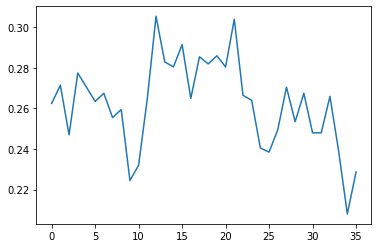

In [15]:
plt.plot(ret)